In [1]:
import csv
feeling = ['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
training_data = []
with open('isear_train.csv', 'r') as f:
    f_csv = csv.reader(f)
    for row in f_csv:
        if row[1] in feeling:
            feeling_list = [0, 0, 0, 0, 0, 0, 0]
            feeling_list[feeling.index(row[1])] = 1
            row[1] = feeling_list
            training_data.append(row)

testing_data = []
with open('isear_test.csv', 'r') as f:
    f_csv = csv.reader(f)
    for row in f_csv:
        if row[1] in feeling:
            feeling_list = [0, 0, 0, 0, 0, 0, 0]
            feeling_list[feeling.index(row[1])] = 1
            row[1] = feeling_list
            testing_data.append(row)

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
training_sentences = []
training_motions = []
for id, motion, words in training_data:\
    
    training_sentences.append(words)
    training_motions.append(motion)
training_motions = np.array(training_motions).astype('int32')
# sentence to sequence
tokenizer = Tokenizer(num_words=None,
                        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
                        lower=True,
                        split=' ',
                        oov_token="oov")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
# add padding and truncating
training_padding = pad_sequences(training_sequences, padding='post', truncating='post', maxlen=200)

testing_sentences = []
testing_motions = []
for id, motion, words in testing_data:
    testing_sentences.append(words)
    testing_motions.append(motion)
testing_motions = np.array(testing_motions).astype('int32')
# sentence to sequence
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
# add padding and truncating
testing_padding = pad_sequences(testing_sequences, padding='post', truncating='post', maxlen=200)

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def generate_plt(history):
    
  epochs=range(10)
    
  plt.plot(epochs, history['accuracy'], 'r')
  plt.plot(epochs, history['val_accuracy'], 'g')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Accuracy", "Validation Accuracy"])
  plt.figure()

  plt.plot(epochs, history['loss'], 'r')
  plt.plot(epochs, history['val_loss'], 'g')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["Loss", "Validation Loss"])
  plt.figure()

  plt.plot(epochs, history['val_f1_macro'], 'r')
  plt.plot(epochs, history['val_f1_micro'], 'g')
  plt.xlabel("Epochs")
  plt.ylabel("Score")
  plt.legend(["Macro Score", "Micro Score"])
  plt.figure()

from sklearn.metrics import recall_score, precision_score, f1_score
class F1_score(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(F1_score, self).__init__()
        self.validation_data = valid_data
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_f1_macro = f1_score(val_targ, val_predict, average='macro',zero_division=0)
        val_f1_micro = f1_score(val_targ, val_predict, average='micro',zero_division=0)
        val_recall = recall_score(val_targ, val_predict, average='macro',zero_division=0)
        val_precision = precision_score(val_targ, val_predict, average='macro',zero_division=0)
        logs['val_f1_macro'] = val_f1_macro
        logs['val_f1_micro'] = val_f1_micro
        logs['val_recall'] = val_recall
        logs['val_precision'] = val_precision
        print("f1_macro: %f - f1_micro: %f — precision: %f — recall: %f" % (val_f1_macro, val_f1_micro, val_precision, val_recall))
        return

In [9]:
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        kernel_sizes = [1, 2, 3, 4]
        self.emb = tf.keras.layers.Embedding(input_dim=10000, output_dim=50, input_length=200)
        self.convs = []
        self.pools = []
        for kernel_size in kernel_sizes:
            self.convs.append(tf.keras.layers.Conv1D(filters=128, kernel_size=kernel_size, activation='relu'))
            self.pools.append(tf.keras.layers.GlobalMaxPooling1D())
        self.concat = tf.keras.layers.Concatenate()
        self.dense = tf.keras.layers.Dense(units=7, activation=tf.nn.softmax)
        
    def call(self, inputs):
        
        x = self.emb(inputs)
        convs = []
        for i in range(4):
            c = self.convs[i](x)
            p = self.pools[i](c)
            convs.append(p)
        x = self.concat(convs)
        output = self.dense(x)
        return output
    
    def build_graph(self):
        x = tf.keras.Input(shape=200,batch_size=100)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

epochs = 10
batch_size = 100

cnn_model = CNN()

cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],
              )

cnn_history = cnn_model.fit(training_padding, training_motions,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(testing_padding,testing_motions),
                  callbacks=F1_score(valid_data=(testing_padding,testing_motions)))

Epoch 1/10
46/46 [==============================] - 6s 106ms/step - loss: 1.9396 - accuracy: 0.1775 - val_loss: 1.8955 - val_accuracy: 0.3901
f1_macro: 0.371600 - f1_micro: 0.390085 — precision: 0.487776 — recall: 0.388595
Epoch 2/10
46/46 [==============================] - 4s 95ms/step - loss: 1.8363 - accuracy: 0.4715 - val_loss: 1.6590 - val_accuracy: 0.4514
f1_macro: 0.443180 - f1_micro: 0.451402 — precision: 0.528562 — recall: 0.452290
Epoch 3/10
46/46 [==============================] - 4s 97ms/step - loss: 1.4881 - accuracy: 0.5694 - val_loss: 1.3182 - val_accuracy: 0.5421
f1_macro: 0.538081 - f1_micro: 0.542074 — precision: 0.540991 — recall: 0.540011
Epoch 4/10
46/46 [==============================] - 4s 95ms/step - loss: 1.0847 - accuracy: 0.6794 - val_loss: 1.1911 - val_accuracy: 0.5760
f1_macro: 0.572454 - f1_micro: 0.575995 — precision: 0.576651 — recall: 0.573152
Epoch 5/10
46/46 [==============================] - 4s 95ms/step - loss: 0.7751 - accuracy: 0.7842 - val_loss: 

Model: "cnn_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     multiple                  500000    
_________________________________________________________________
conv1d_44 (Conv1D)           multiple                  6528      
_________________________________________________________________
conv1d_45 (Conv1D)           multiple                  12928     
_________________________________________________________________
conv1d_46 (Conv1D)           multiple                  19328     
_________________________________________________________________
conv1d_47 (Conv1D)           multiple                  25728     
_________________________________________________________________
global_max_pooling1d_44 (Glo multiple                  0         
_________________________________________________________________
global_max_pooling1d_45 (Glo multiple                  0    

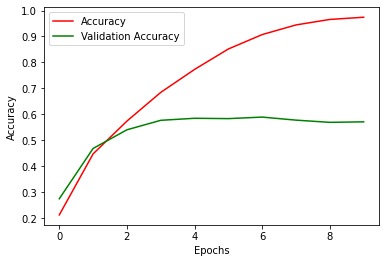

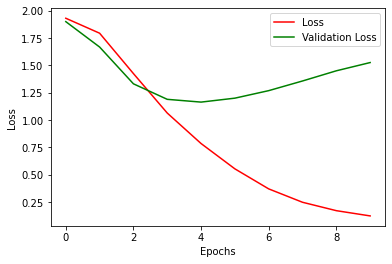

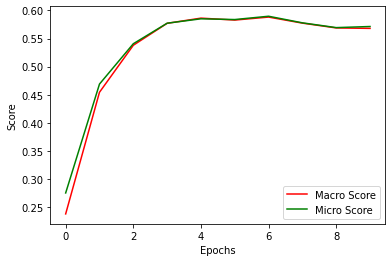

<Figure size 432x288 with 0 Axes>

In [44]:
cnn_model.summary()
tf.keras.utils.plot_model(cnn_model.build_graph(), to_file='CNN.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=96, expand_nested=True)
generate_plt(cnn_history.history)

In [45]:
class LSTM(tf.keras.Model):
    def __init__(self):
        super(LSTM, self).__init__()
        self.emb = tf.keras.layers.Embedding(input_dim=10000,output_dim=128, input_length=200)
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))
        self.dense1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=7, activation=tf.nn.softmax)
        
    def call(self, inputs, training=None, mask=None):
        x = self.emb(inputs)
        x = self.lstm(x)
        x = self.dense1(x)
        output = self.dense2(x)
        return output
    
    def build_graph(self):
        x = tf.keras.Input(shape=200,batch_size=100)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

epochs = 10
batch_size = 100

rnn_model = LSTM()
rnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],
              )
rnn_history = rnn_model.fit(training_padding, training_motions,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(testing_padding, testing_motions),
                  callbacks=F1_score(valid_data=(testing_padding,testing_motions)))

Epoch 1/10
46/46 [==============================] - 28s 560ms/step - loss: 1.9401 - accuracy: 0.1662 - val_loss: 1.8316 - val_accuracy: 0.2668
f1_macro: 0.197963 - f1_micro: 0.266797 — precision: 0.463397 — recall: 0.266206
Epoch 2/10
46/46 [==============================] - 24s 518ms/step - loss: 1.7249 - accuracy: 0.3143 - val_loss: 1.5903 - val_accuracy: 0.3862
f1_macro: 0.359841 - f1_micro: 0.386171 — precision: 0.370673 — recall: 0.382972
Epoch 3/10
46/46 [==============================] - 24s 531ms/step - loss: 1.2547 - accuracy: 0.5455 - val_loss: 1.4764 - val_accuracy: 0.4677
f1_macro: 0.466362 - f1_micro: 0.467710 — precision: 0.491735 — recall: 0.466301
Epoch 4/10
46/46 [==============================] - 28s 603ms/step - loss: 0.8554 - accuracy: 0.6951 - val_loss: 1.5309 - val_accuracy: 0.4899
f1_macro: 0.493636 - f1_micro: 0.489889 — precision: 0.517056 — recall: 0.486316
Epoch 5/10
46/46 [==============================] - 25s 551ms/step - loss: 0.6216 - accuracy: 0.8020 - v

Model: "lstm_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     multiple                  1280000   
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  263168    
_________________________________________________________________
dense_25 (Dense)             multiple                  32896     
_________________________________________________________________
dense_26 (Dense)             multiple                  903       
Total params: 1,576,967
Trainable params: 1,576,967
Non-trainable params: 0
_________________________________________________________________


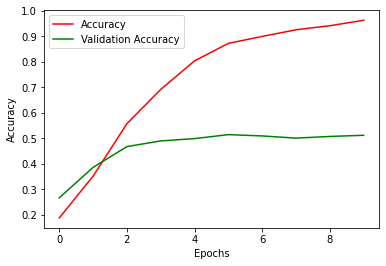

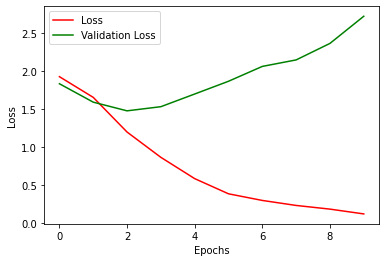

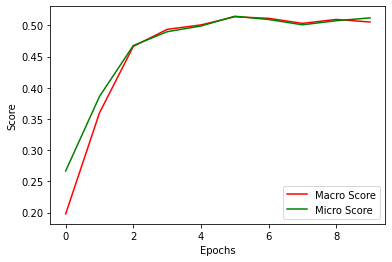

<Figure size 432x288 with 0 Axes>

In [46]:
rnn_model.summary()
tf.keras.utils.plot_model(rnn_model.build_graph(), to_file='RNN.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=96, expand_nested=True)
generate_plt(rnn_history.history)

In [6]:
class MLP(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(units=1000, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=7)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        output = tf.nn.softmax(x)
        return output
    
    def build_graph(self):
        x = tf.keras.Input(shape=200,batch_size=100)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

epochs = 10
batch_size = 100

mlp_model = MLP()
mlp_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'],
              )
mlp_history = mlp_model.fit(training_padding, training_motions,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(testing_padding, testing_motions),
                  callbacks=F1_score(valid_data=(testing_padding,testing_motions)))

Epoch 1/10
46/46 [==============================] - 1s 7ms/step - loss: 173.9431 - accuracy: 0.1550 - val_loss: 81.0739 - val_accuracy: 0.1344
f1_macro: 0.124084 - f1_micro: 0.134377 — precision: 0.134326 — recall: 0.135233
Epoch 2/10
46/46 [==============================] - 0s 4ms/step - loss: 65.6494 - accuracy: 0.2250 - val_loss: 69.5713 - val_accuracy: 0.1487
f1_macro: 0.143767 - f1_micro: 0.148728 — precision: 0.146244 — recall: 0.149168
Epoch 3/10
46/46 [==============================] - 0s 3ms/step - loss: 42.2327 - accuracy: 0.2782 - val_loss: 63.5084 - val_accuracy: 0.1383
f1_macro: 0.130687 - f1_micro: 0.138291 — precision: 0.133970 — recall: 0.141324
Epoch 4/10
46/46 [==============================] - 0s 4ms/step - loss: 34.3920 - accuracy: 0.3116 - val_loss: 63.9699 - val_accuracy: 0.1468
f1_macro: 0.134973 - f1_micro: 0.146771 — precision: 0.140691 — recall: 0.148443
Epoch 5/10
46/46 [==============================] - 0s 3ms/step - loss: 29.5963 - accuracy: 0.3378 - val_lo

Model: "mlp_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (100, 1000)               201000    
_________________________________________________________________
dense_23 (Dense)             (100, 7)                  7007      
Total params: 208,007
Trainable params: 208,007
Non-trainable params: 0
_________________________________________________________________


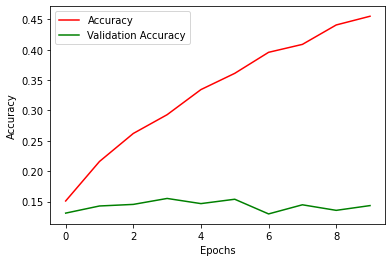

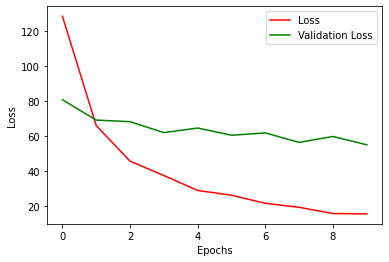

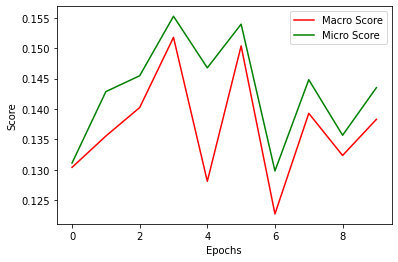

<Figure size 432x288 with 0 Axes>

In [41]:
mlp_model.summary()
tf.keras.utils.plot_model(mlp_model.build_graph(), to_file='MLP.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=96, expand_nested=True)
generate_plt(mlp_history.history)